# 선형 회귀 (Linear Regression)

Date: 2019-08-15  
Author: skettee  
Categories: Deep Learning, Linear Regression  
Tags: Loss function, Mean-squared error, Gradient Descent, Normalization
<!--eofm-->


딥러닝의 세계로 들어가기 위해 알아야 하는 첫번째 모델인 선형 회귀(Linear Regression)에 대해 알아보고 keras를 이용해서 모델링을 해보자!
<!--more-->

실제로 돌려 보고 싶으면 구글 코랩으로 ~  

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/skettee/notebooks/blob/master/linear_regression.ipynb)


## 문제 (Problem)

💰 고객  
 
> 우리 학교에는 '몸짱반'이 있어요.   
> 여기에 들어가기 위해서는   
> 키와 몸무게의      
> 특별한 조건이 있는거 같아요.  
>
> '몸짱반'에 들어간 친구들의   
> 키와 몸무게 데이터를 가지고   
> 키가 주어지면   
> '몸짱반'에 들어가기 위한 몸무게를  
> 자동으로 알고 싶어요...  
>
> 만들어 줄 수 있지요? 
>
> 데이터는 아래에 있어요  
> https://skettee.github.io/post/linear_regression/momjjangban_data.csv



## 데이터 수집 (Data Collection)

데이터를 다운로드하고 데이터프레임으로 변환한다.  

Keras의 get_file을 이용해서 데이터를 다운로드 한다.

In [1]:
from tensorflow.keras.utils import get_file

fname = 'momjjangban_data.csv'
origin = 'https://skettee.github.io/post/linear_regression/momjjangban_data.csv'
path = get_file(fname, origin)

CSV파일을 읽어서 데이터프레임으로 변환한다.  

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv(path, index_col=0)

df.head()

,height,weight
0,158.9,52.015
1,173.6,66.910
2,174.4,66.000
3,169.2,NaN
4,154.0,49.275


## 데이터 클렌징 (Data Cleansing)

데이터가 빵꾸난 것이 없는지 확인한다. 빵꾸난 데이터는 제거한다.  

⚙️ 엔지니어

> 얼굴만 클렌징하는거 아니다...  
> 데이터도 클렌징해야 한다.  

In [3]:
# Check nan
df.isnull().any()

height    True
weight    True
dtype: bool

In [4]:
# Remove row with nan
df = df.dropna(axis=0).reset_index(drop=True)

df.head()

,height,weight
0,158.9,52.015
1,173.6,66.910
2,174.4,66.000
3,154.0,49.275
4,177.7,69.820


In [5]:
height_data = df.height
weight_data = df.weight

print(height_data.shape)
print(weight_data.shape)

(50,)
(50,)


## 데이터 분석 (Data Analysis)

데이터가 어떤 모양인지 확인해 보자.

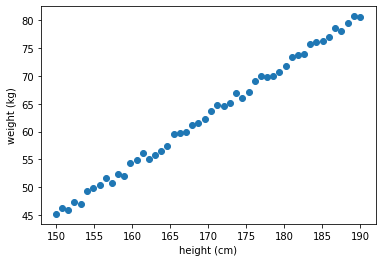

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.scatter(height_data, weight_data)
plt.xlabel('height (cm)')
plt.ylabel('weight (kg)')
plt.show()

⚙️ 엔지니어

> 키가 커질 수록 몸무게가 선형(Linear)적으로 늘어나네~   
> 직선으로 모델링을 할 수 있겠다.
> 
> 모델링 작업이 편안하도록 주어진 데이터를 변환하자!

## 데이터 변환 (Data Transformation)

Keras, tensorflow등의 머신런닝 프레임워크를 사용하기 위해서는  
각각이 요구하는 데이터의 형식 및 모양에 맞추어서 변환을 해 주어야 한다.  
여기서는  키와 몸무게 데이터를 각각 매트릭스로 변환하자  

- 열의 크기는 데이터의 개수      
- 컬럼의 크기는 측정한 항목의 개수   
 
키 값을 입력하면 '몸짱반'에 들어갈 수 있는 몸무게를 예측해야 한다. 키 데이터를 입력 $x$라고 하고 몸무게 데이터를 출력 $y$라고 하자 

- 키 데이터는 50개의 '키'를 측정한 데이터가 있으므로 50X1 매트릭스   
- 몸무게 데이터는 50개의 '몸무게'를 측정한 데이터가 있으므로 50X1 매트릭스이다.  

⚙️ 엔지니어

> 모델링을 하면서 골치 아픈 것 중에 하나는  
> 입력과 출력의 모양(Shape)를 맞추어 주는 것이다.  
> 복잡하다 ... 잘못하면 다크-디멘션에 빠진다...   
> 뒤에서 더 자세하게 설명할 기회가 있을 것이다.  



In [7]:
x = np.array(height_data).reshape(len(height_data), 1)
y = np.array(weight_data).reshape(len(weight_data), 1)

print('x = ', x[:10])
print('x.shape= ', x.shape)
print('\ny = ', y[:10])
print('y.shape= ', y.shape)

x =  [[158.9]
 [173.6]
 [174.4]
 [154. ]
 [177.7]
 [188.3]
 [183.4]
 [168.7]
 [185.1]
 [156.5]]
x.shape=  (50, 1)

y =  [[52.015]
 [66.91 ]
 [66.   ]
 [49.275]
 [69.82 ]
 [79.479]
 [75.685]
 [61.569]
 [76.346]
 [51.694]]
y.shape=  (50, 1)


⚙️ 엔지니어

> 좋았어!   
> 
> 그럼 변환된 데이터로 선형회귀(Linear Regression) 모델링을 시작해 보지

## 선형 모델링 (Linear Modeling)

모델을 $y=wx+b$로 놓고   
주어진 데이터에 가장 비슷한 직선을 표시하는 $w$와 $b$를 찾아 가는 것이 선형 모델링이다.  
$w$는 직선의 기울기고 $b$는 $y$절편이라고 배웠지만, 이제 부터는 $w$는 **가중치(weight)** 로, $b$는 **바이어스(bias)** 로 부르자

⚙️ 엔지니어) 

> 그런데... $w$와 $b$를 어떻게 구하면 되지?


### 손실 함수 (Loss function)

⚙️ 엔지니어

> 남여 커플 10명이 모여서 게임을 시작한다.  
> 남자는 여자친구의 몸무게를 말하고 가장 비슷한 몸무게를 맞추는 커플이 1등이 된다.  
> 1등을 정하는 방법은 남자가 말한 몸무게와 여자친구가 말한 실제 몸무게의 차이를 점수로 계산하고,  
> 가장 점수가 낮은(가장 비슷하게 맞춘) 커플에게 1등을 주면 된다.  
>
> 실제로 점수를 계산할 때에는 단순한 차이값을 사용하지 않고  
> 차이값을 제곱하고 반으로 나누어 준 값을 사용한다.    
>
> 그리고 커플 10명 전체에 대한 점수는 각 커플들의 점수의 평균을 내면 된다.

하나의 데이터 세트($x^{(i)}, y^{(i)}$)를 사용해서 모델에서 얻은 값과 실제 값과의 차이(Loss)를 구하는 함수를 구해보자.  
여기서 $x^{(i)}$는 i번째 $x$값이고 $y^{(i)}$은 i번째 $y$값이다.  

일단 $w$와 $b$는 임의의 값으로 놓자. 그리고 모델에 $x^{(i)}$을 넣고 계산한 결과 값 ${\hat y}^{(i)}$과 실제 값 $y^{(i)}$의 차이를 구한다. 선형 모델링에서는 제곱 오차(squred error)를 사용한다.

$L({\hat y}^{(i)}, y^{(i)})={1\over2}({\hat y}^{(i)}-y^{(i)})^2$

모든 데이터(m개의 데이터 세트)로 부터 얻은 것을 평균(mean squred error)한것이 손실 함수(Loss function)이다. 손실 함수는 $w$와 $b$의 함수로 나타낼 수 있다.

$\begin{align}
{\large J}(w, b) & = {1\over m}\sum_{i=1}^m L({\hat y}^{(i)}, y^{(i)}) \\
\\
& = {1\over {2m}}\sum_{i=1}^m ({\hat y}^{(i)}-y^{(i)})^2
\end{align}$

⚙️ 엔지니어

> 손실 함수   
> 
> ${\large J}(w, b) = {1\over {2m}}\sum_{i=1}^m ({\hat y}^{(i)}-y^{(i)})^2$  
>
> 가 최소가 되는 $w$와 $b$를 찾으면 되겠군!

**손실 함수 (Loss function) 시각화**

우선 손실 함수(Loss function)가 어떻게 생겨 먹었는지 살펴 보자.  
x축을 $w$로 놓고, y축을 $b$로 놓고, z축을 손실 함수 $J(w, b)$로 그래프를 그려 보면 어떻게 최소값을 찾을지 감이 올 것 같다.   

$w$는 $-5\leqq w \leqq 5$ 정도로 잡고,   
$b$는 $-5\leqq b \leqq 5$으로 잡아보자.  



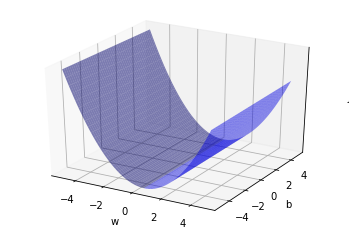

In [8]:
import numpy as np
from sklearn.metrics import mean_squared_error
from mpl_toolkits import mplot3d

# W,b의 범위를 결정한다.
w = np.arange(-5.0, 5.0, 0.1)
b = np.arange(-5.0, 5.0, 0.1)
j_array = []

W, B = np.meshgrid(w, b)

# w, b를 하나씩 대응한다.
for we, be in zip(np.ravel(W), np.ravel(B)):
    y_hat = np.add(np.multiply(we, x), be)
    # Loss function
    mse = mean_squared_error(y_hat, y) / 2.0
    j_array.append(mse)

# 손실(Loss)을 구한다.
J = np.array(j_array).reshape(W.shape)

# 서피스 그래프를 그린다.
fig = plt.figure()
ax = plt.axes(projection="3d")

ax.plot_surface(W, B, J, color='b', alpha=0.5)
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('J')
ax.set_zticks([])
plt.show()

⚙️ 엔지니어

> U 모양으로 구부러진 모양이다!  
> $w$가 1근처에서 손실 함수가 최소값을 가지는 것을 볼 수 있다.  
>
> $b$는 손실 함수가 최소가 되는 값이 잘 보이지 않는다.   
> 확대를 하면 보이겠지만 귀찮다.  
>
> 이제 램덤하게 $w$와 $b$값이 주어지더라도   
> 자동으로 손실 함수의 최소값을 찾는 방법을 찾으면 된다.  
>
> 어떻게 자동으로 찾지?

### 경사 하강법 (Gradient Descent)

⚙️ 엔지니어

> 등산에서 쓰는 말처럼 들리는 이 방법은  
> 내가 현재 있는 산의 위치에서   
> 경사(기울기)를 확인하고   
> 경사가 아래인 방향으로 한걸음 내려가고,   
> 경사를 확인하고,   
> 또 한걸음 내려가고를   
> 계속 반복하면   
> 결국 골짜기 가장 아래로 도착할 수 있다는 방법이다.    
>
> 여기서 경사를 확인 하는 방법이   
> **미분**이다.   
> 
> 잘 모르겠다고?   
> 아래에 간단한 예제를 보자

**이차 함수에서 미분으로 최소값 찾기**

$y=x^2-2x+4$에서 $y$가 최소가 되는 $x$값을 미분으로 구해 보자.  
* 참고로 $y=(x-1)^2 +3$으로 정리하면 $x=1$일때 $y$는 최소값 3을 갖는다는 것을 알 수 있다.  

![이차 함수에서 미분으로 최소값 찾기](https://skettee.github.io/post/linear_regression/gd_graph.png)

1. $x$값을 아무거나 하나 선택한다. 여기서는 $x=3$을 선택하자
2. $x=3$일때 순간 변화율을 계산한다. 순간 변화율은 미분이다. ${dy\over dx}=2x-2$ 이므로 순간 변화율은 4이다.
3. 순간 변화율이 0보다 크면 $x$를 -방향으로 이동한다. 이떄 얼마나 이동하느냐가 중요한데 순간 변화율 4만큼 이동하면 최소값을 지나쳐 버린다. 따라서 조금씩 움직이도록 순간 변화율에 0.01배 만큼 움직이게 한다. ($x$를 0.04 만큼 -방향으로 이동한다. 즉 $x=2.96$)
4. 순간 변화율이 0보다 작으면 x를 +방향으로 이동한다. 위와 마찬가지로 미분값에 0.01배 만큼 움직이게 한다. 여기서 0.01을 learning rate라고 하고 $\alpha$로 표시한다.
5. 2번에서 4번까지의 과정을 **epoch** 라고 한다.
6. 업데이트 된 x값을 가지고 2, 3, 4번을 반복한다. 1000번 반복한다. (1000 epoch)



In [4]:
def derivative(x):
    dydx = 2*x-2
    return dydx
    
epoch = 1000 # 반복 회수
learning_rate = 0.01 # alpha

xx = 3 # 초기 x값

for i in range(epoch):
    xx = xx - learning_rate * derivative(xx)
    
print('x for minimum y is: ', xx)

x for minimum y is:  1.0000000033659349


$w$와 $b$에 대한 손실 함수의 순간 변화율(미분값)을 구해서 반복해서 업데이트를 해 주면 자동으로 손실 함수의 최소 값에 도달 할 수 있다.     

수식으로 표현해보자

REPEAT(epoch) {    

$\begin{align}
w: &=w-\alpha \dfrac{\partial J(w,b)}{\partial w} \\    
b:  &=b-\alpha \dfrac{\partial J(w,b)}{\partial b}
\end{align}$  
}  
$\alpha=0.001$ learining rate    

⚙️ 엔지니어

> 아하! 손실함수의 최소값을 찾아 가는 것이 기계(Machine)가 학습(Learning)하는 방법이구나!

### 정리

선형 모델(Linear model)을 만드는 방법을 정리해 보자.  

1. $\hat{y}=wx+b$ 함수를 정의한다.  
2. 손실 함수 (Loss function)를 정의한다. 여기서는 **평균 제곱 오차(mean squared error)** 를 사용한다.  
3. 손실 함수의 최소값을 찾는 방법을 선택한다. 여기서는 **경사 하강법(gradient descent)** 을 사용한다. 그리고 최소값을 찾는 방법(알고리즘)을 **옵티마이저(Optimizer)** 라고 부르겠다.  
4. 반복할 회수(epoch)를 결정한다.  
5. 주어진 조건으로 모델을 최적화(fit) 시킨다.  

## 케라스(Keras)로 모델링(Modeling)

⚙️ 엔지니어

> 좋았어!   
> 
> 이제 텐서플로우(Tensorflow)가 냠냠한   
> **케라스(Keras)**를 이용해서 구현을 해보자!

### 정규화(Normalization)
  
`정규값 = (현재값 - 최소값) / (최대값-최소값)` 으로 정규화 하자  
 
그래프를 보면,  
데이터의 모양은 그대로 유지하면서도  
x축의 값이 0에서 1사이로 변환된 것을 볼 수 있다.  

⚙️ 엔지니어  

> 내가 해봐서 아는데...   
> 
> 이거 안하면 엉뚱한 답이 나온다.
> 꼭 해야됨!



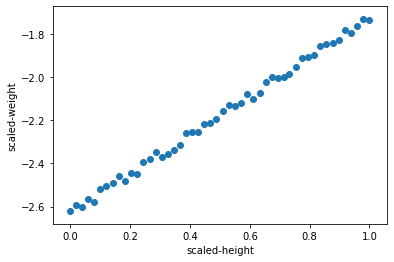

In [10]:
from sklearn import preprocessing

mm_scaler = preprocessing.MinMaxScaler()
X_train = mm_scaler.fit_transform(x)
Y_train = mm_scaler.transform(y)

plt.scatter(X_train, Y_train)
plt.xlabel('scaled-height')
plt.ylabel('scaled-weight')
plt.show()

### 모델링 (Modeling)

⚙️ 엔지니어

> 4줄로 모델링이 가능하다!   
> 
> 케라스 만세!



In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# 모델을 준비한다.
model = Sequential()

# 입력 변수의 개수가 1이고 출력 개수가 1인 y=wx+b 를 생성한다.
model.add(Dense(1, input_dim=1))

# Loss funtion과 Optimizer를 선택한다.
model.compile(loss='mean_squared_error', optimizer='sgd') 

# epochs만큼 반복해서 손실값이 최저가 되도록 모델을 훈련한다.
hist = model.fit(X_train, Y_train, epochs=3000, verbose=0) 

W0914 02:05:15.168387 140504936548160 deprecation.py:506] From /home/dataman/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### 손실값의 변화를 그래프로 확인

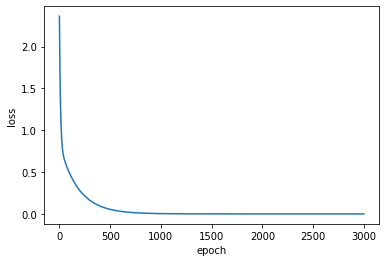

In [12]:
plt.plot(hist.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

⚙️ 엔지니어

> 반복적으로 학습할 수록 손실(Loss)이 0에 가깝게 된다.  
> 굿잡!

### $w$와 $b$값을 확인

In [13]:
w, b = model.get_weights()
w =  w[0][0]
b = b[0]
print('w: ', w)
print('b: ', b)

w:  0.89876956
b:  -2.6253219


### 그래프로 확인

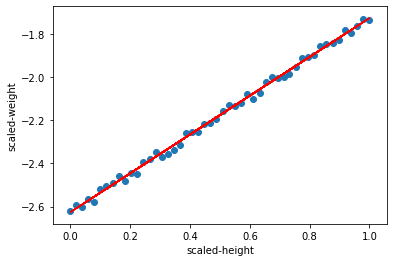

In [14]:
x_scale = mm_scaler.transform(x)
y_scale = mm_scaler.transform(y)
plt.scatter(x_scale, y_scale)
plt.plot(x_scale, w*x_scale+b, 'r')
plt.xlabel('scaled-height')
plt.ylabel('scaled-weight')
plt.show()

## 해결 (Solution)

⚙️ 엔지니어  

> 고객님~ 원하시는 솔루션입니다.   
> input_height에 원하시는 키를 입력하시면    
> '몸짱반'에 들어 갈 수 있는 몸무게가 자동으로 계산됩니다.    



In [15]:
input_height = 178.0

input_x = mm_scaler.transform(np.array([input_height]).reshape(-1, 1))
predict = model.predict(input_x)
predict = mm_scaler.inverse_transform(predict)

print('몸짱반에 들어갈 수 있는 몸무게는 {:.2f} kg 입니다'.format(predict[0][0]))

몸짱반에 들어갈 수 있는 몸무게는 70.15 kg 입니다
